In [ ]:
# default_exp subcoco_ivf

In [ ]:
#hide
from nbdev.showdoc import *

# Exploring Object Detection using Icevision w/ FastAI

I was unable to make much progress using Pytorch Lightning & Torch Vision on a tiny subset of Coco Dataset. 
I got a model to run for hundreds of epochs, with seemingly improving training loss, but prediction is still garbage.

So I decided to get an end to end object detection working example before diving back in. This time I chose https://github.com/airctic/icevision

Following their [first example](https://airctic.com/examples/training/) for FastAI...

In [ ]:
#export 
import fastai
import icevision
import icevision.backbones as backbones
import icevision.models
import icevision.models.efficientdet as efficientdet
import icevision.models.rcnn.faster_rcnn as faster_rcnn
import icevision.tfms as tfms
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import PIL
import pytorch_lightning as pl
import re
import requests
import tarfile
import sys
import torch
import torchvision
import xml.etree.ElementTree

from albumentations import ShiftScaleRotate
from collections import defaultdict
from functools import reduce
from fastai.callback.training import GradientAccumulation
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback, TerminateOnNaNCallback
from icevision.core import BBox, ClassMap
from icevision.data import Dataset
from icevision.metrics.coco_metric import COCOMetricType, COCOMetric
from icevision.parsers import Parser
from icevision.parsers.mixins import LabelsMixin, BBoxesMixin, FilepathMixin, SizeMixin
from icevision.utils import denormalize_imagenet
from icevision.visualize.show_data import *
from IPython.utils import io
from pathlib import Path
from PIL import Image, ImageStat
from tqdm import tqdm
from typing import Hashable, List, Union

In [ ]:
print(f"Python ver {sys.version}, torch {torch.__version__}, torchvision {torchvision.__version__}, fastai {fastai.__version__}, pytorch_lightning {pl.__version__}, icevision {icevision.__version__}")

%matplotlib inline

Python ver 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0], torch 1.6.0, torchvision 0.7.0, fastai 2.0.16, pytorch_lightning 0.9.0, icevision 0.1.6


## Download a Sample of COCO Data

The full COCO Dataset is huge (~50GB?). For my self education exploring object detection, with the intention of using pretrained model in transfer learning, it is not practical to deal with dataset this big as my first project.  Luckily, the kind folks at [FastAI](https://fast.ai) have prepared some convenient subsets, the medium size 3GB https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz seems like a good candidate.  The 800KB "http://files.fast.ai/data/examples/coco_tiny.tgz" on the other hand seems way too small, thus may not have enough data for adequate training.

However, to allow faster iteration, let's start with the tiny dataset just to test drive the whole process...

In [ ]:
#export

def fetch_data(url:str, datadir: Path, tgt_fname:str, chunk_size:int=8*1024, quiet=False):
    dest = datadir/tgt_fname
    if not quiet: print(f"Downloading from {url} to {dest}...")
    with requests.get(url, stream=True, timeout=10) as response:
        content_len = int(response.headers['content-length'])
        with open(dest, 'wb') as f:
            with tqdm(total=content_len) as pbar:
                nbytes = 0
                num_chunks = 0
                for chunk in response.iter_content(chunk_size=chunk_size):
                    chunk_len = len(chunk)
                    nbytes += chunk_len
                    num_chunks += 1
                    f.write(chunk)
                    pbar.update(chunk_len)

    with tarfile.open(dest, 'r') as tar:
        extracted = []
        for item in tar:
            tar.extract(item, datadir)
            extracted.append(item.name)

    if not quiet: print(f"Downloaded {nbytes} from {url} to {dest}, extracted in {datadir}: {extracted[:3]},...,{extracted[-3:]}")

In [ ]:
datadir = Path("workspace")

# froot = "coco_tiny"
# fname = f"{froot}.tgz"
# url = f"http://files.fast.ai/data/examples/{fname}"
# json_fname = datadir/froot/'train.json'
# img_dir = datadir/froot/'train'

# If using the bigger Coco subset, use these values
froot = "coco_sample"
fname = f"{froot}.tgz"
url = f"https://s3.amazonaws.com/fast-ai-coco/{fname}"
json_fname = datadir/froot/'annotations'/'train_sample.json'
img_dir = datadir/froot/'train_sample'

if not os.path.isdir(datadir/froot): 
    fetch_data(url, datadir, fname, chunk_size=1024*1024)

## Check Annotations

Let's load and inspect the annotation file that comes with the coco tiny dataset...

In [ ]:
with open(json_fname, 'r') as json_f:
    train_json = json.load(json_f)
    
train_json['categories'], train_json['images'][0], [a for a in train_json['annotations'] if a['image_id']==train_json['images'][0]['id'] ]

([{'id': 62, 'name': 'chair'},
  {'id': 63, 'name': 'couch'},
  {'id': 72, 'name': 'tv'},
  {'id': 75, 'name': 'remote'},
  {'id': 84, 'name': 'book'},
  {'id': 86, 'name': 'vase'}],
 {'id': 318219, 'file_name': '000000318219.jpg'},
 [{'image_id': 318219,
   'bbox': [505.24, 0.0, 47.86, 309.25],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [470.68, 0.0, 45.93, 191.86],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [442.51, 0.0, 43.39, 119.87],
   'category_id': 72}])

## Digest the Dataset for useful Stats

Do some basic analysis of the data to get numbers like total images, boxes, and average box count per image...

In [ ]:
#export

# cannot use lambda as pickling may fail when saving models
def empty_list(): return []

class CocoDatasetStats():
    # num_cats
    # num_imgs
    # num_bboxs
    # cat2name
    # class_map
    # lbl2cat
    # cat2lbl
    # img2fname
    # imgs
    # img2cat2bs
    # img2cbs
    # cat2ibs
    # avg_ncats_per_img
    # avg_nboxs_per_img
    # avg_nboxs_per_cat
    # img2sz
    # chn_means
    # chn_stds
    # avg_width
    # avg_height
    def __init__(self, ann:dict, img_dir:Path):
        
        self.img_dir = img_dir
        self.num_cats = len(ann['categories'])
        self.num_imgs = len(ann['images'])
        self.num_bboxs = len(ann['annotations'])
        
        # build cat id to name, assign FRCNN 
        self.cat2name = { c['id']: c['name'] for c in ann['categories'] }
        self.class_map = ClassMap(list(self.cat2name.values()))
        
        # need to translate coco subset category id to indexable label id
        # expected labels w 0 = background
        self.lbl2cat = { self.class_map.get_name(n): c for c, n in self.cat2name.items() }
        self.cat2lbl = { c: l for l, c in self.lbl2cat.items() }
        self.lbl2cat[0] = (0, 'background')
        self.cat2lbl[0] = 0
        
        # img_id to file map
        self.img2fname = { img['id']:img['file_name'] for img in ann['images'] }
        self.imgs = [ { 'id':img_id, 'file_name':img_fname } for (img_id, img_fname) in self.img2fname.items() ]

        # compute Images per channel means and std deviation using PIL.ImageStat.Stat()
        
        self.img2sz = {}
        n = 0
        mean = np.zeros((3,))
        stddev = np.zeros((3,))
        avgw = 0
        avgh = 0
        for img in tqdm(self.imgs):
            img_id = img['id']
            fname = img_dir/img['file_name']
            n = n + 1
            img = Image.open(fname)
            istat = ImageStat.Stat(img)
            width, height = img.size
            avgw = (width + (n-1)*avgw)/n
            avgh = (height + (n-1)*avgh)/n
            # self.img2l2bs[img_id][0].append( (width/3., height/3., width/3., height/3., ) ) # hack to add a backgrnd box
            mean = (istat.mean + (n-1)*mean)/n
            stddev = (istat.stddev + (n-1)*stddev)/n
            self.img2sz[img_id] = (width, height)
        
        self.chn_means = mean
        self.chn_stds = stddev
        self.avg_width = avgw
        self.avg_height = avgh
        
        # build up some maps for later analysis        
        self.img2l2bs = {}
        self.img2lbs = defaultdict(empty_list)
        self.l2ibs = defaultdict(empty_list)
        anno_id = 0
        for a in ann['annotations']:
            img_id = a['image_id']
            cat_id = a['category_id']
            lbl_id = self.cat2lbl[cat_id]
            l2bs_for_img = self.img2l2bs.get(img_id, { l:[] for l in range(1+len(self.cat2name))})
            (x, y, w, h) = a['bbox']
            b = (x, y, w, h) 
            ib = (img_id, *b)
            lb = (lbl_id, *b)
            l2bs_for_img[lbl_id].append(b)
            self.l2ibs[lbl_id].append(ib)
            self.img2lbs[img_id].append(lb)
            self.img2l2bs[img_id] = l2bs_for_img
            
        acc_ncats_per_img = 0.0
        acc_nboxs_per_img = 0.0
        for img_id, l2bs in self.img2l2bs.items():
            acc_ncats_per_img += len(l2bs)
            for lbl_id, bs in l2bs.items():
                acc_nboxs_per_img += len(bs)

        self.avg_ncats_per_img = acc_ncats_per_img/self.num_imgs
        self.avg_nboxs_per_img = acc_nboxs_per_img/self.num_imgs

        acc_nboxs_per_cat = 0.0
        for lbl_id, ibs in self.l2ibs.items():
            acc_nboxs_per_cat += len(ibs)

        self.avg_nboxs_per_cat = acc_nboxs_per_cat/self.num_cats
        

def load_stats(ann:dict, img_dir:Path, force_reload:bool=False):
    stats_fpath = img_dir/'stats.pkl'
    stats = None
    if os.path.isfile(stats_fpath) and not force_reload:
        try:
            stats = pickle.load( open(stats_fpath, "rb" ) )
        except Exception as e:
            print(f"Failed to read precomputed stats: {e}")

    if stats == None:
        stats = CocoDatasetStats(ann, img_dir)
        pickle.dump(stats, open(stats_fpath, "wb" ) )
        
    return stats

In [ ]:
stats = load_stats(train_json, img_dir=img_dir, force_reload=False) 
print(
    f"Categories {stats.num_cats}, Images {stats.num_imgs}, Boxes {stats.num_bboxs}, avg (w,h) {(stats.avg_width, stats.avg_height)}"
    f"avg cats/img {stats.avg_ncats_per_img:.1f}, avg boxs/img {stats.avg_nboxs_per_img:.1f}, avg boxs/cat {stats.avg_nboxs_per_cat:.1f}.")

print(f"Image means by channel {stats.chn_means}, std.dev by channel {stats.chn_stds}")
{ stats.cat2name[stats.lbl2cat[lid]]: len(ibs) for lid, ibs in stats.l2ibs.items()}

Categories 6, Images 21837, Boxes 87106, avg (w,h) (575.6857626963424, 481.71420066859)avg cats/img 7.0, avg boxs/img 4.0, avg boxs/cat 14517.7.
Image means by channel [115.64436835 103.2992867   91.73613059], std.dev by channel [64.16724017 62.63021182 61.92975836]


{'tv': 5805,
 'book': 24715,
 'chair': 38491,
 'vase': 6613,
 'remote': 5703,
 'couch': 5779}

In [ ]:
stats.cat2name, stats.lbl2cat

({62: 'chair', 63: 'couch', 72: 'tv', 75: 'remote', 84: 'book', 86: 'vase'},
 {1: 62, 2: 63, 3: 72, 4: 75, 5: 84, 6: 86, 0: (0, 'background')})

## Custom Parser

In [ ]:
#export

def box_within_bounds(x, y, w, h, width, height, min_margin_ratio, min_width_height_ratio):
    min_width = min_width_height_ratio*width
    min_height = min_width_height_ratio*height
    if w < min_width or h < min_height:
        return False
    top_margin = min_margin_ratio*height
    bottom_margin = height - top_margin
    left_margin = min_margin_ratio*width
    right_margin = width - left_margin
    if x < left_margin or x > right_margin:
        return False
    if y < top_margin or y > bottom_margin:
        return False
    return True

class SubCocoParser(Parser, LabelsMixin, BBoxesMixin, FilepathMixin, SizeMixin):
    def __init__(self, stats:CocoDatasetStats, min_margin_ratio = 0.15, min_width_height_ratio = 0.1, quiet = True):
        self.stats = stats
        self.data = [] # list of tuple of form (img_id, wth, ht, bbox, label_id, img_path)
        skipped = 0
        for img_id, imgfname in stats.img2fname.items():
            imgf = stats.img_dir/imgfname
            width, height = stats.img2sz[img_id]
            bboxs = []
            lids = []
            for lid, x, y, w, h in stats.img2lbs[img_id]:
                if lid != None and box_within_bounds(x, y, w, h, width, height, min_margin_ratio, min_width_height_ratio): 
                    b = [int(x), int(y), int(w), int(h)]
                    l = int(lid)
                    bboxs.append(b)
                    lids.append(l)
                else:
                    if not quiet: print(f"warning: skipping lxywh of {lid, x, y, w, h}")
            
            if len(bboxs) > 0:
                self.data.append( (img_id, width, height, bboxs, lids, imgf, ) )
            else:
                skipped += 1
                
        print(f"Skipped {skipped} out of {stats.num_imgs} images")

    def __iter__(self):
        yield from iter(self.data)

    def __len__(self):
        return len(self.data)

    def imageid(self, o) -> Hashable:
        return o[0]

    def filepath(self, o) -> Union[str, Path]:
        return o[5]

    def height(self, o) -> int:
        return o[2]

    def width(self, o) -> int:
        return o[1]

    def labels(self, o) -> List[int]:
        return o[4]

    def bboxes(self, o) -> List[BBox]:
        return [BBox.from_xywh(x,y,w,h) for x,y,w,h in o[3]]

In [ ]:
parser = SubCocoParser(stats)
train_records, valid_records = parser.parse()
len(train_records), len(valid_records)

Skipped 11282 out of 21837 images


(8444, 2111)

## shows images with corresponding labels and boxes

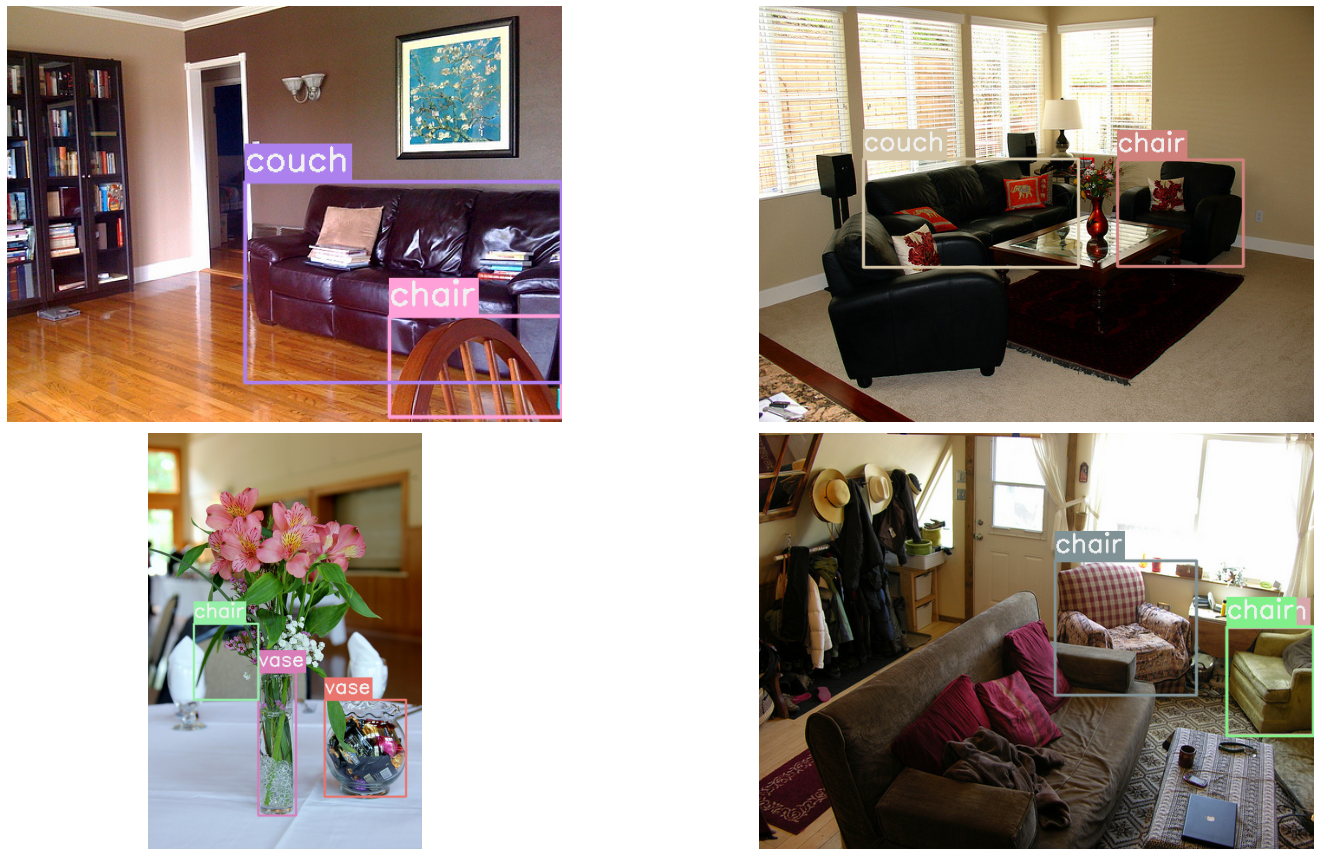

In [ ]:
show_records(train_records[:4], ncols=2, class_map=stats.class_map, show=True)

## Define transforms - using Albumentations transforms out of the box

In [ ]:
size=512
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=size+128), tfms.A.Normalize(mean=stats.chn_means, std=stats.chn_stds)])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize(mean=stats.chn_means, std=stats.chn_stds)])

## Create both training and validation datasets

In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

## Create Model, Training and Validation Dataloaders

In [ ]:
bs=32
acc_cycs = 1
# backbone_name = "resnet_fpn.resnet18"
# backbone = backbones.resnet_fpn.resnet18(pretrained=True)
# # backbone = backbones.resnet_fpn.resnet34(pretrained=True)
# # backbone = backbones.resnet_fpn.resnet50(pretrained=True) # Default
# # backbone = backbones.resnet_fpn.resnet101(pretrained=True)
# # backbone = backbones.resnet_fpn.resnet152(pretrained=True)
# # backbone = backbones.resnet_fpn.resnext50_32x4d(pretrained=True)
# # backbone = backbones.resnet_fpn.resnext101_32x8d(pretrained=True)
# # backbone = backbones.resnet_fpn.wide_resnet50_2(pretrained=True)
# # backbone = backbones.resnet_fpn.wide_resnet101_2(pretrained=True)
# model = faster_rcnn.model(backbone=backbone, num_classes=len(stats.class_map))
backbone_name = "tf_efficientdet_lite0"
model = efficientdet.model(model_name=backbone_name, img_size=size, num_classes=len(stats.class_map))
train_dl = efficientdet.train_dl(train_ds, batch_size=bs//acc_cycs, num_workers=6, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=bs//acc_cycs, num_workers=6, shuffle=False)

## Train using FastAI

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)

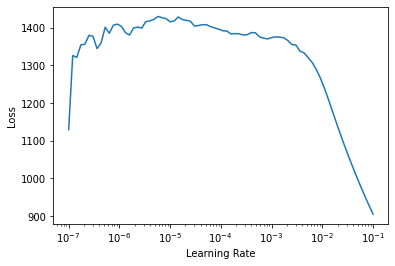

In [ ]:
monitor_metric = 'COCOMetric'
metrics = [ COCOMetric(metric_type=COCOMetricType.bbox)]

save_model_fname=f'{backbone_name}-{size}'
callbacks=[
    #TerminateOnNaNCallback(),
    #GradientAccumulation(bs), 
    SaveModelCallback(fname=save_model_fname, monitor=monitor_metric),
    EarlyStoppingCallback(monitor=monitor_metric, min_delta=0.001, patience=50)
]

learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics, cbs=callbacks)
learn.freeze()
learn.lr_find()

In [ ]:
min_lr, epochs, freeze_epochs = 1e-2, 200, 20
print(f"Running with image size {size} for {freeze_epochs}+{epochs} epochs at min LR {min_lr}")
learn.fine_tune(epochs, min_lr, freeze_epochs=freeze_epochs)

Running with image size 512 for 20+200 epochs at min LR 0.01


epoch,train_loss,valid_loss,COCOMetric,time
0,91.417389,87.680267,0.000002,03:59
1,3.543656,2.874059,0.004330,03:41
2,1.326249,1.154266,0.040131,03:42
3,1.050785,0.901936,0.140499,03:36
4,0.930640,0.798001,0.230779,03:40
5,0.883881,0.754764,0.246723,03:44
6,0.839142,0.713697,0.296157,03:43
7,0.814802,0.705848,0.299801,03:43
8,0.811192,0.690190,0.300134,03:40
9,0.789569,0.707025,0.283419,03:42


Better model found at epoch 0 with COCOMetric value: 2.1683012406607563e-06.
Better model found at epoch 1 with COCOMetric value: 0.004330147192447274.
Better model found at epoch 2 with COCOMetric value: 0.04013133314337608.
Better model found at epoch 3 with COCOMetric value: 0.14049915870413537.
Better model found at epoch 4 with COCOMetric value: 0.23077875778119605.
Better model found at epoch 5 with COCOMetric value: 0.24672266929470366.
Better model found at epoch 6 with COCOMetric value: 0.29615710662220146.
Better model found at epoch 7 with COCOMetric value: 0.29980118108497705.
Better model found at epoch 8 with COCOMetric value: 0.3001341498497603.
Better model found at epoch 10 with COCOMetric value: 0.32128288591598436.
Better model found at epoch 14 with COCOMetric value: 0.33589189919034274.
Better model found at epoch 17 with COCOMetric value: 0.34275294646411403.
Better model found at epoch 18 with COCOMetric value: 0.36333518045643887.
Better model found at epoch 19 

epoch,train_loss,valid_loss,COCOMetric,time
0,0.677372,0.567584,0.390703,04:06
1,0.663165,0.599369,0.357724,03:59
2,0.658727,0.593195,0.359909,04:09
3,0.644924,0.584505,0.377263,04:04
4,0.635327,0.572383,0.382580,04:05
5,0.635523,0.559085,0.417350,04:07
6,0.627038,0.558674,0.397522,04:06
7,0.613541,0.555253,0.422143,04:10
8,0.622723,0.709786,0.299441,04:05
9,0.618178,0.643454,0.356255,04:09


Better model found at epoch 0 with COCOMetric value: 0.39070290386740014.
Better model found at epoch 5 with COCOMetric value: 0.41735040005239177.
Better model found at epoch 7 with COCOMetric value: 0.42214324726495134.


## Inference

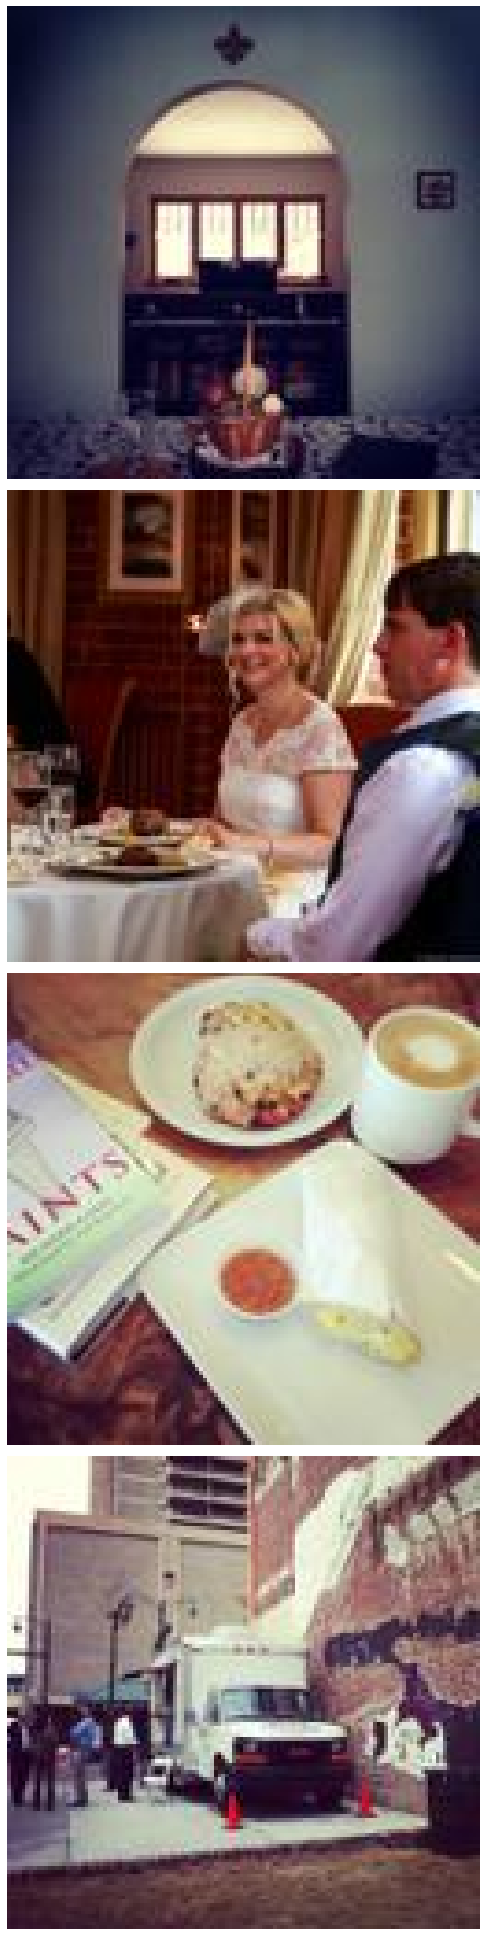

In [ ]:
infer_dl = efficientdet.infer_dl(valid_ds, batch_size=4, shuffle=True)
samples, preds = efficientdet.predict_dl(model, infer_dl)
imgs = [sample["img"] for sample in samples]
show_preds(
    imgs=imgs[:4],
    preds=preds[:4],
    class_map=stats.class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=1,
    figsize=(36,27)
)

## Saving Model Explicitly

Saving it explicitly after 10 epochs.

In [ ]:
model_save_path = f"models/{save_model_fname}-final.pth"
torch.save(model.state_dict(), model_save_path)

In [ ]:
model_save_path = f"models/{save_model_fname}-final.pth"
pretrained_model = efficientdet.model(model_name=backbone_name, num_classes=len(stats.class_map))
pretrained_model.load_state_dict(torch.load(model_save_path))

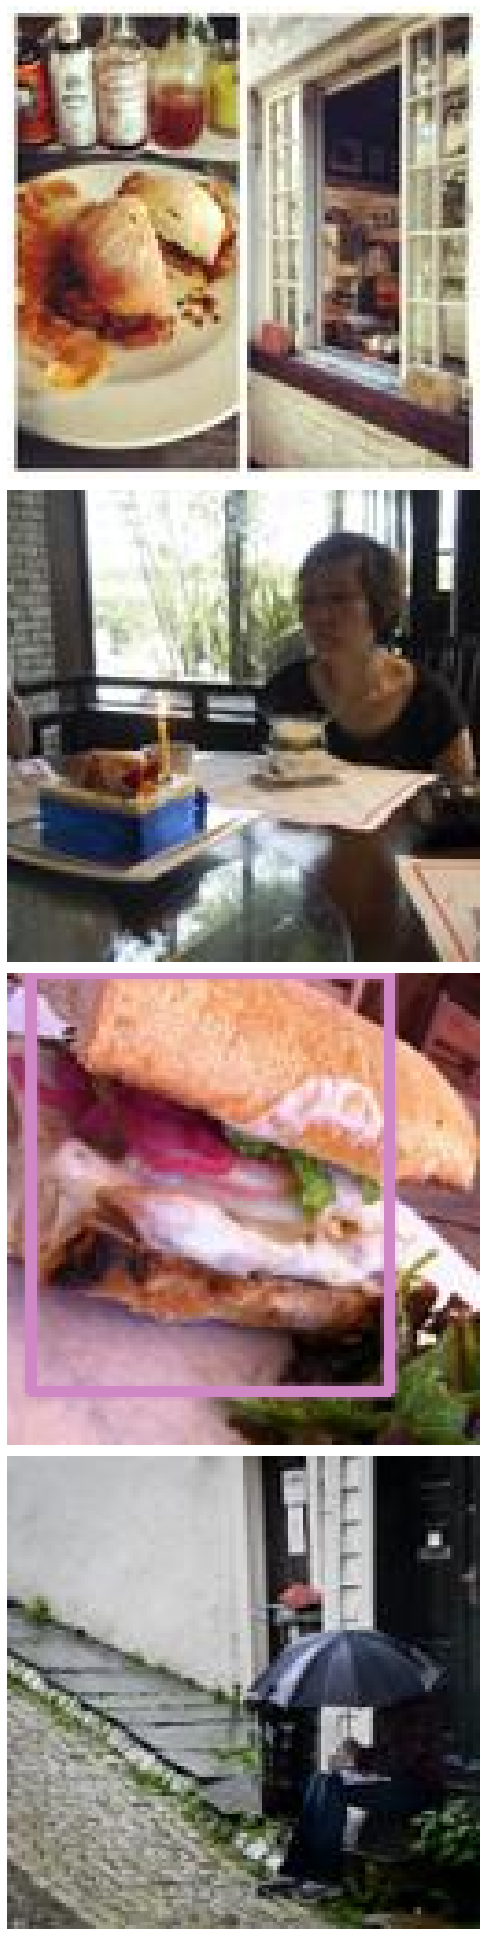

In [ ]:
samples, preds = efficientdet.predict_dl(pretrained_model.cuda(), infer_dl)
imgs = [sample["img"] for sample in samples]
show_preds(
    imgs=imgs[:4],
    preds=preds[:4],
    class_map=stats.class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=1,
    figsize=(36,27)
)

# For Running in Python Standalone

In [ ]:
#export
if __name__ == "__main__":
    projroot = Path.home()/"Projects"/"plmcbbox"
    datadir = projroot/"workspace"
    froot = "coco_sample"
    fname = f"{froot}.tgz"
    url = f"https://s3.amazonaws.com/fast-ai-coco/{fname}"
    json_fname = datadir/froot/'annotations'/'train_sample.json'
    img_dir = datadir/froot/'train_sample'
    if not os.path.isdir(datadir/froot): 
        fetch_data(url, datadir, fname, chunk_size=1024*1024)
    with open(json_fname, 'r') as json_f:
        train_json = json.load(json_f)
    stats = load_stats(train_json, img_dir=img_dir)
    parser = SubCocoParser(stats)
    train_records, valid_records = parser.parse()
    bs=32
    acc_cycs = 4
    size=384
    train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=size+128), tfms.A.Normalize(mean=stats.chn_means, std=stats.chn_stds)])
    valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize(mean=stats.chn_means, std=stats.chn_stds)])
    backbone_name = "tf_efficientdet_lite0"
    model = efficientdet.model(model_name=backbone_name, img_size=size, num_classes=len(stats.class_map))
    train_ds = Dataset(train_records, train_tfms)
    valid_ds = Dataset(valid_records, valid_tfms)
    train_dl = efficientdet.train_dl(train_ds, batch_size=bs//acc_cycs, num_workers=4, shuffle=True)
    valid_dl = efficientdet.valid_dl(valid_ds, batch_size=bs//acc_cycs, num_workers=4, shuffle=False)
    monitor_metric = 'COCOMetric'
    metrics = [ COCOMetric(metric_type=COCOMetricType.bbox)]
    save_model_fname=f'subcoco-{size}'
    callbacks=[
        TerminateOnNaNCallback(),
        GradientAccumulation(bs),
        SaveModelCallback(fname=save_model_fname, monitor=monitor_metric),
        EarlyStoppingCallback(monitor=monitor_metric, min_delta=0.001, patience=40)
    ]

    learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics, cbs=callbacks)
    learn.freeze()
    learn.fine_tune(100, 0.01, freeze_epochs=10)
    model_save_path = projroot/"models"/f"{save_model_fname}-final.pth"
    torch.save(model.state_dict(), model_save_path)

NameError: name 'Path' is not defined